## 0. Dataset
Il dataset contiene immagini MRI assieme alle corrispondenti maschere di segmentazione manuale delle anomalie.

Comprende complessivamente 7 858 file in formato TIFF (circa 2 GB di dati): 3 929 scansioni e 3 929 maschere, ognuna associata all’immagine corrispondente.

[1]: https://www.kaggle.com/mateuszbuda/lgg-MRI-SEGMENTATION?utm_source=chatgpt.com "Brain MRI segmentation | Kaggle"
[2]: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation/notebooks?utm_source=chatgpt.com "Brain MRI segmentation | Kaggle"
[3]: https://medium.com/%40shiza.charania/about-the-brain-mri-segmentation-dataset-on-kaggle-e65b8f24c010?utm_source=chatgpt.com "About the “Brain MRI segmentation” Dataset on Kaggle - Medium"
[4]: https://github.com/imcohen/segment-brain-mri?utm_source=chatgpt.com "Brain MRI segmentation using Kaggle dataset - GitHub"
[5]: https://mateuszbuda.github.io/2017/12/01/brainseg.html?utm_source=chatgpt.com "Segmentation of brain tumor in magnetic resonance images"

Nel corso della seguente trattazione ci si impegna ad implementare un'architettura di tipo U-net per la segmentazione semantica dell'immagine.

In [8]:
# copiare il dataset nella working directory
import kagglehub
mateuszbuda_lgg_mri_segmentation_path = kagglehub.dataset_download('mateuszbuda/lgg-mri-segmentation')
print('Data source import complete.')


Data source import complete.


In [3]:
# librerie utilizzate in seguito
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

# pacchetti specifici per la costruzione e l'allenamento della rete
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import plotly.express as px

# Utilities
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

# 1. Importare il dataset

In [9]:
# Si creano delle liste contenenti i percorsi di maschere ed immagini relative
brain_scans = []
mask_files = glob.glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    brain_scans.append(i.replace('_mask',''))

print(brain_scans[:10])
print(mask_files[:10])

['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_7.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_6.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_38.tif']
['/kaggle/in

## 1.2 Creazione del dataframe finale
In this section we will combine the brain scans with their corresponding 'masks' in a dataframe. Next, we use a function to determine which masks contain a tumor and which masks are empty.

Then we apply the function to the masks in the dataframe and add a column with 0's and 1's, where 0 indicate a mask with no tumor and 1 indicate a mask with a tumor. This dataframe is needed for the classification task, because then the model can get the brain scans as input and train the column with the 0's and 1's as output.

In [10]:
# Si crea un dataframe
img_df = pd.DataFrame({
    "image_path":brain_scans,
    "mask_path":mask_files
})

In [11]:
# visualizzazione del df
img_df

image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
...                                                 ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  

[3929 rows x 2 columns]

# 2. Visualizzazione dei dati

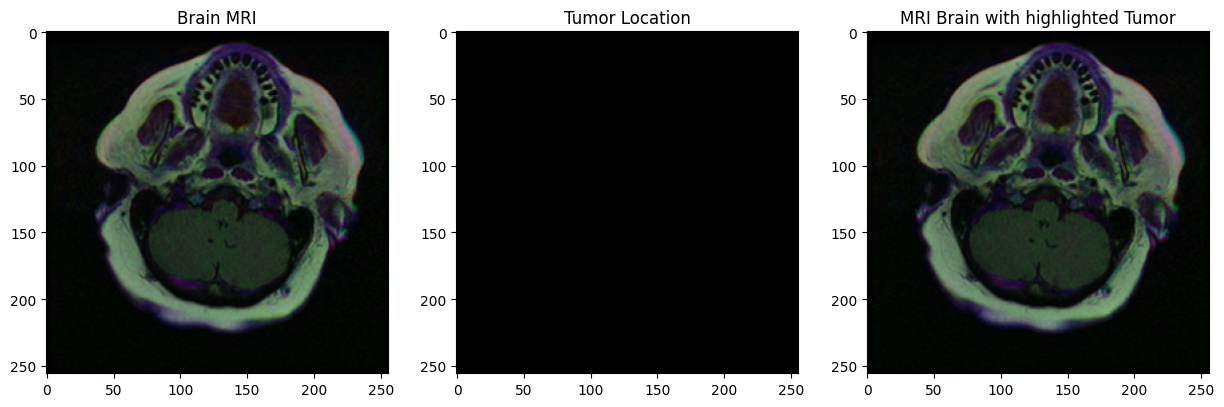

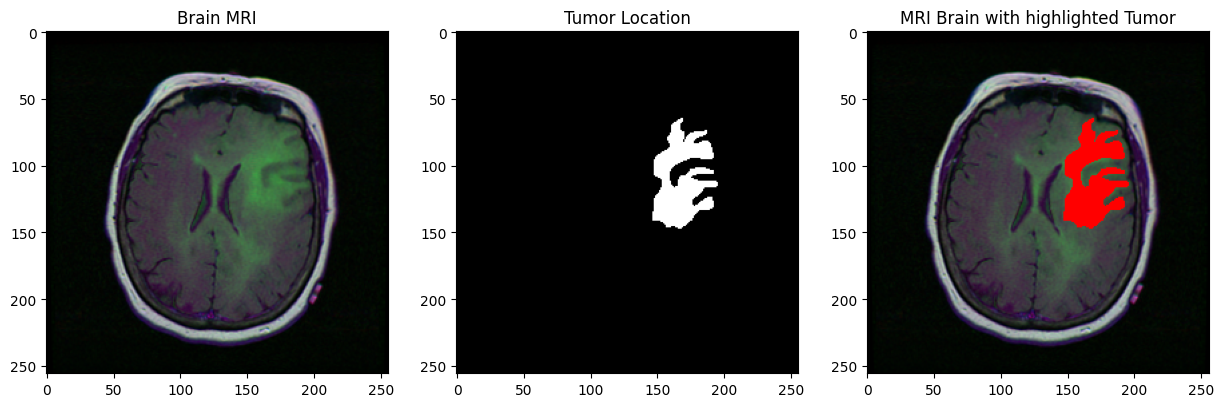

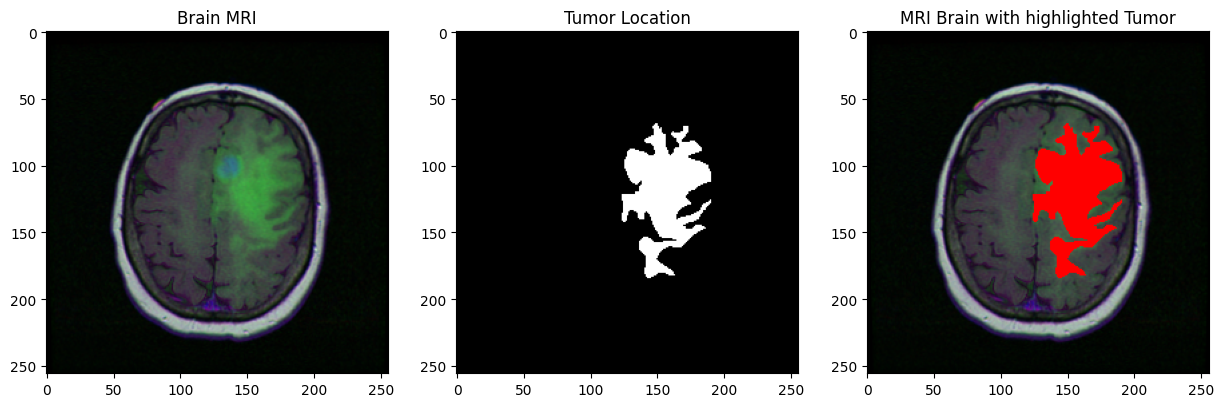

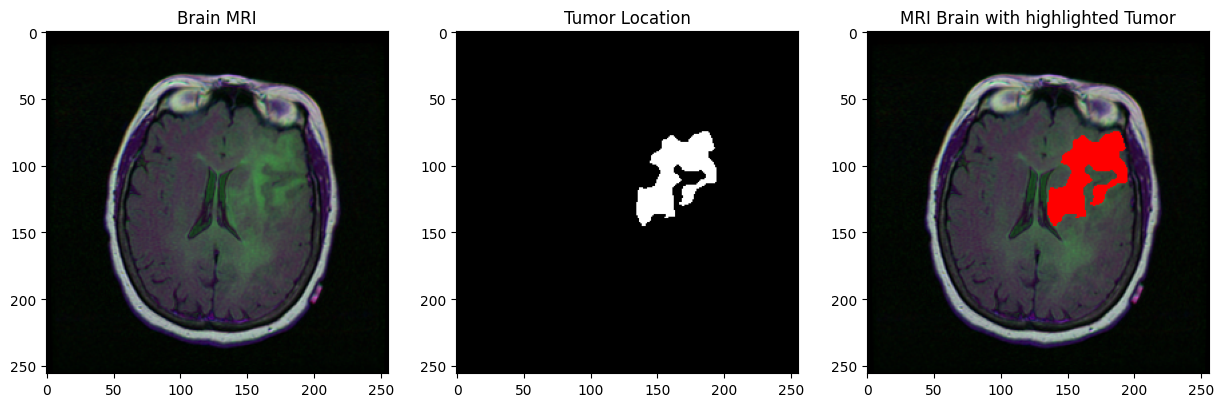

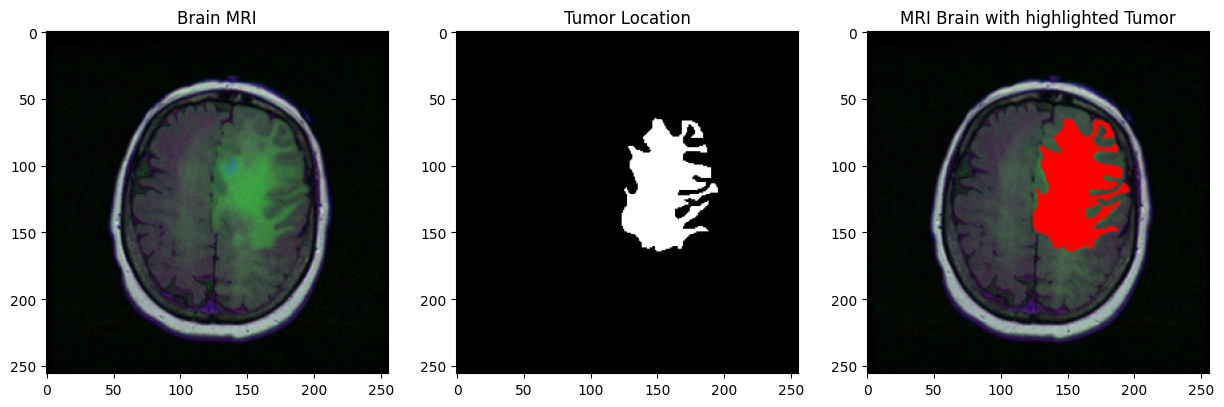

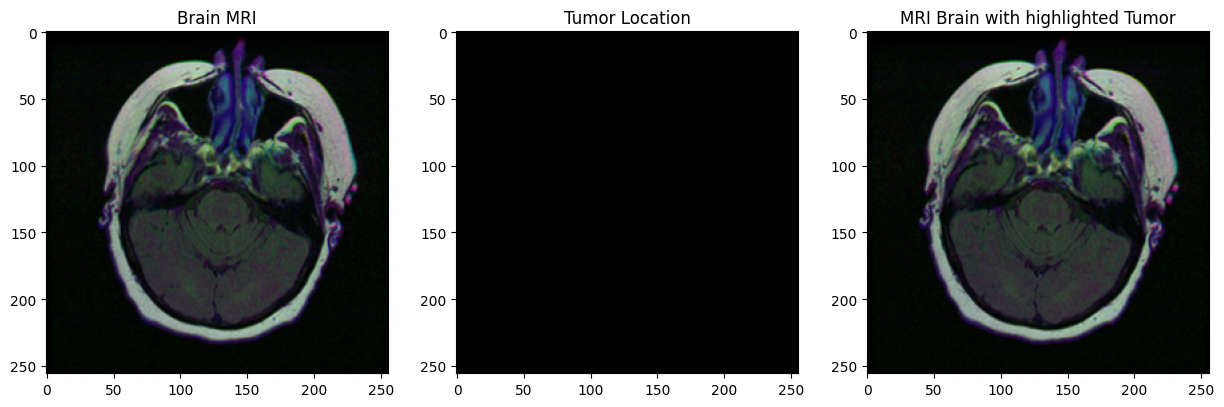

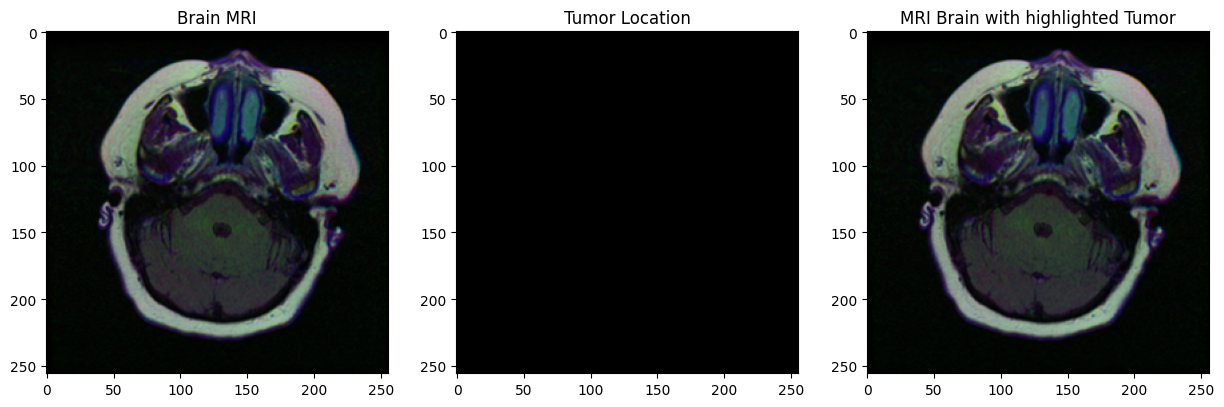

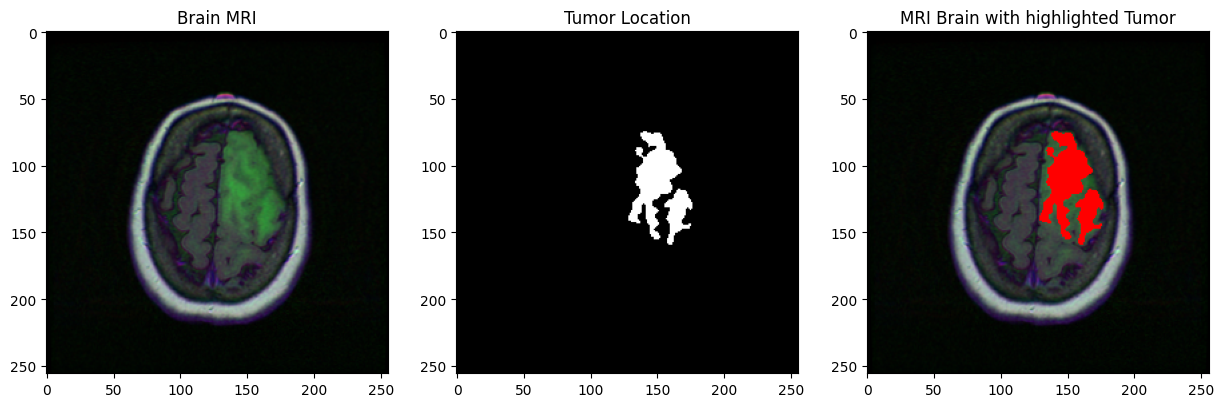

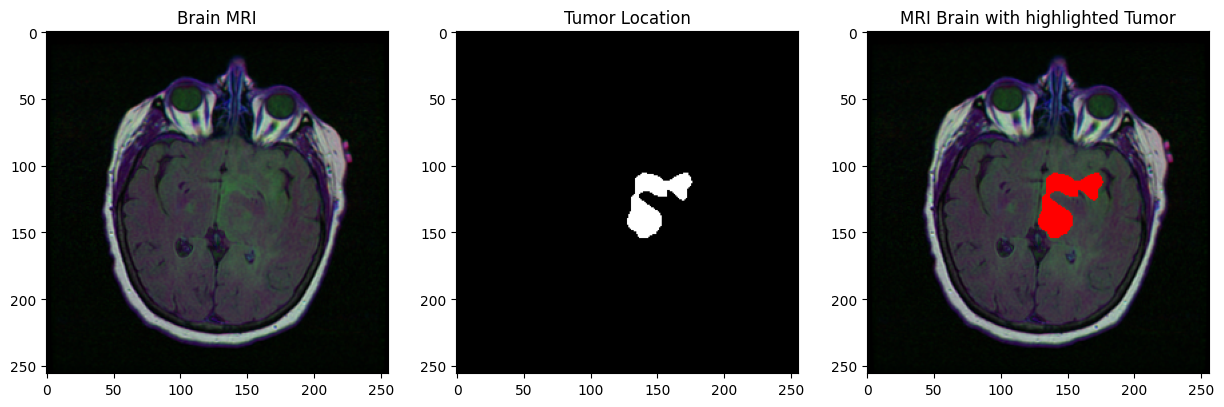

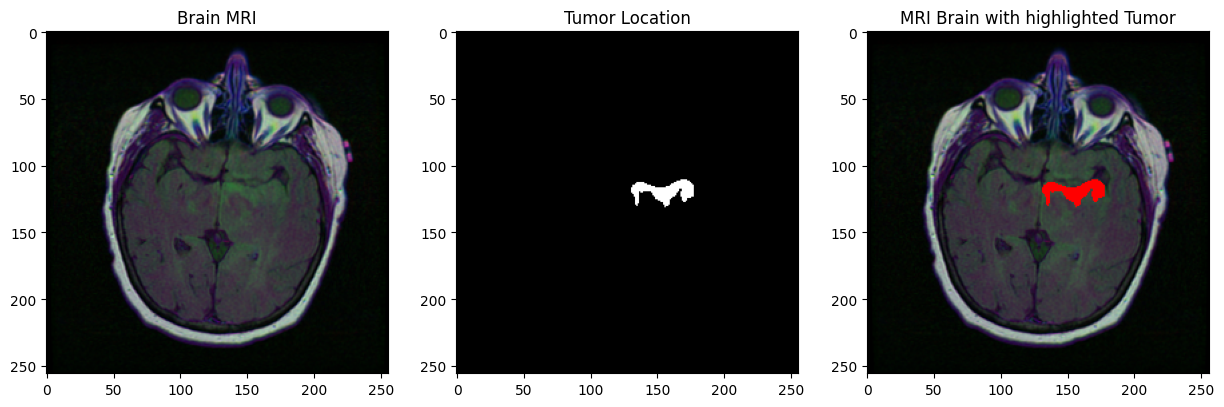

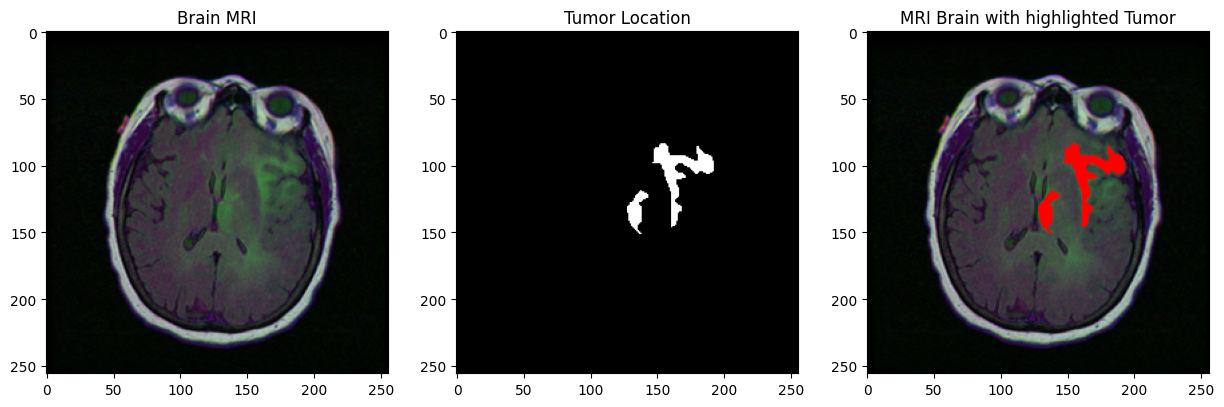

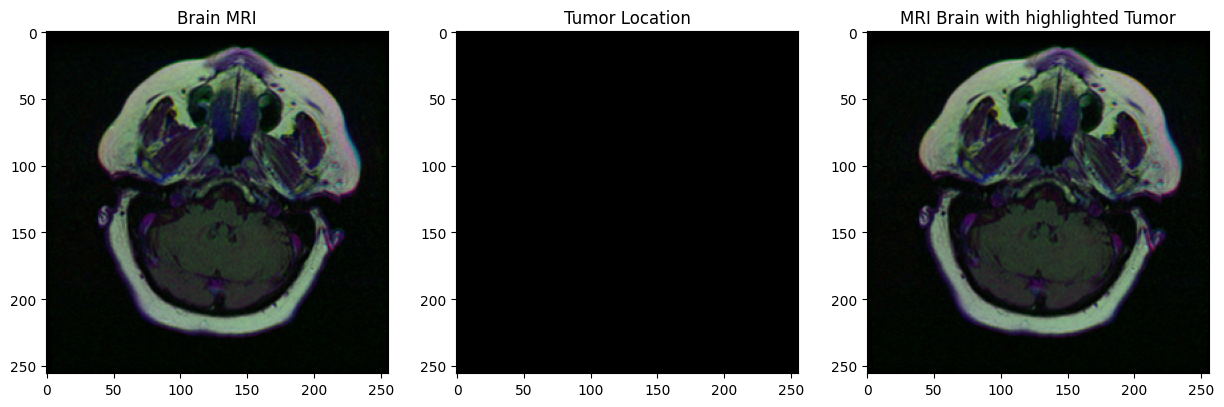

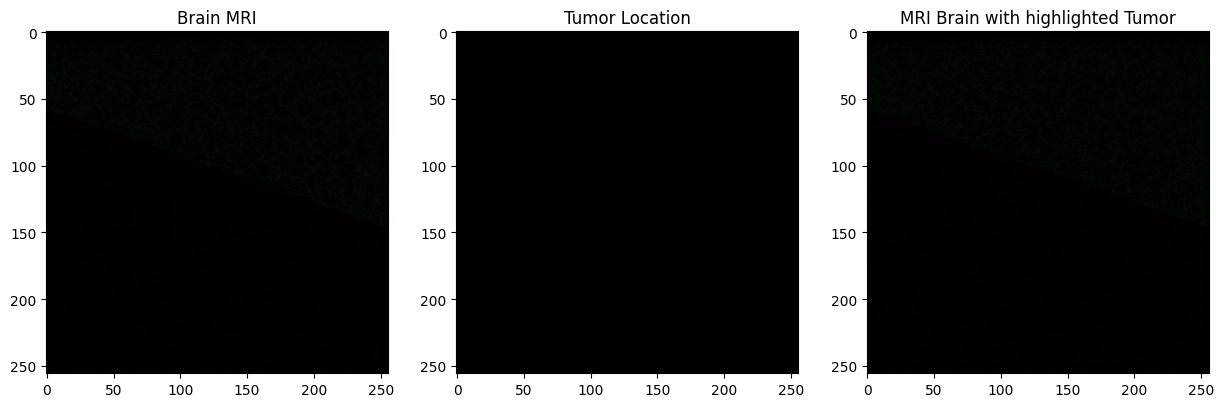

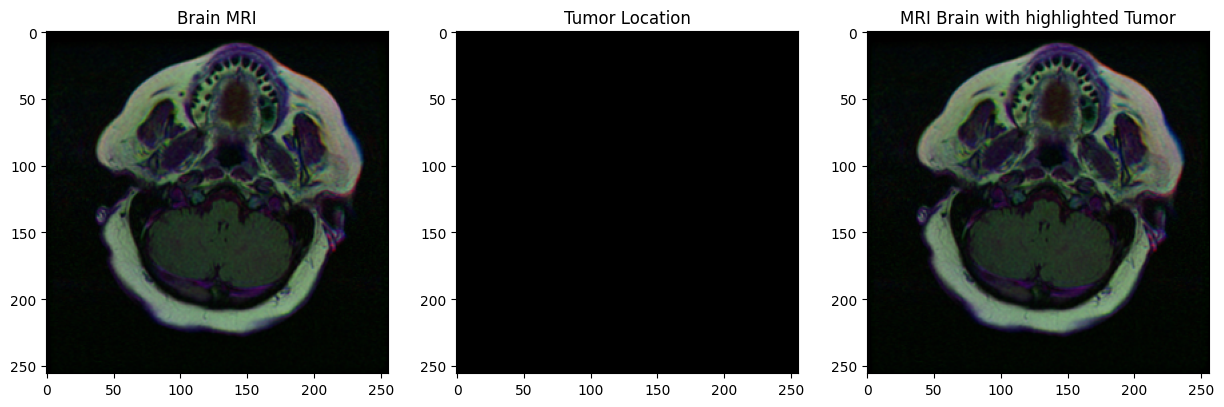

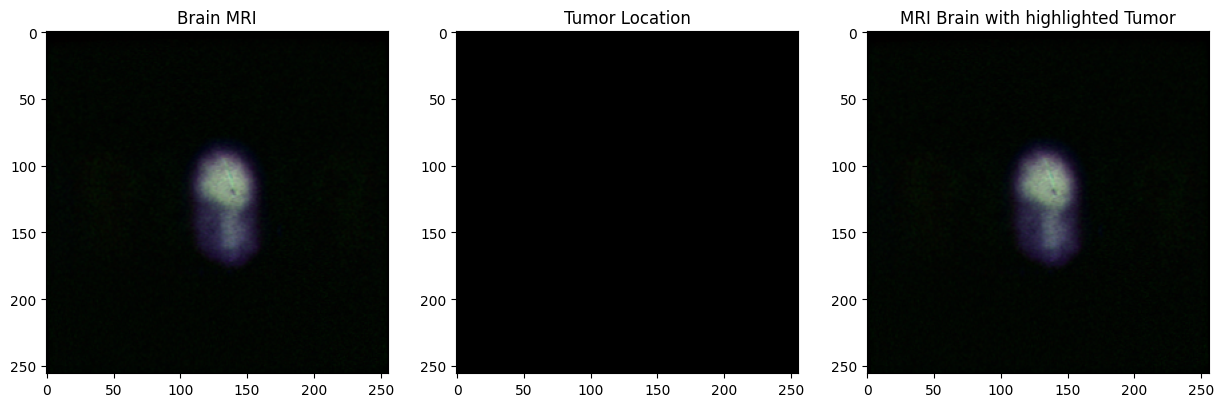

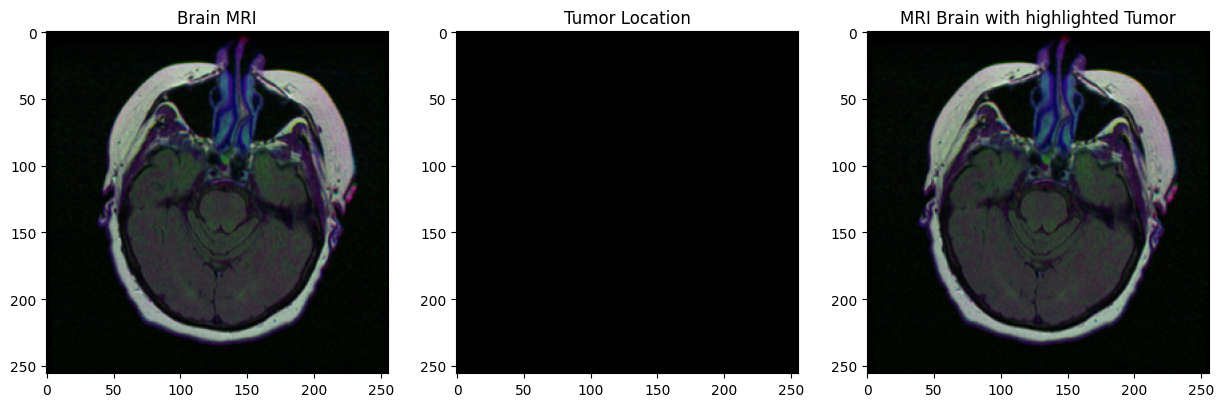

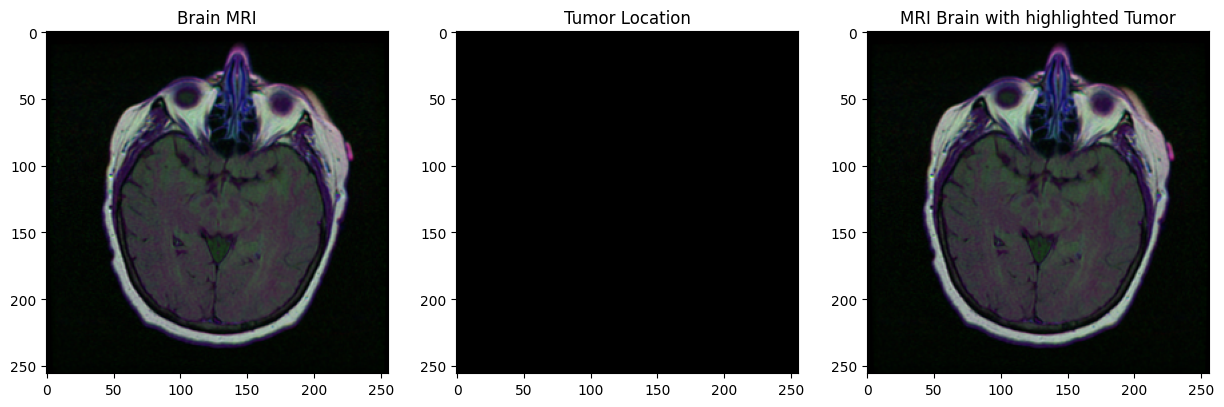

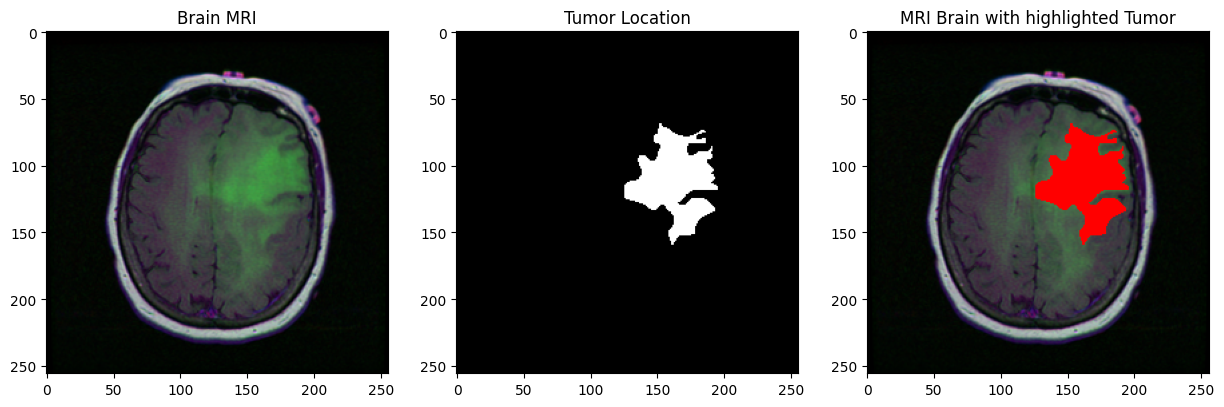

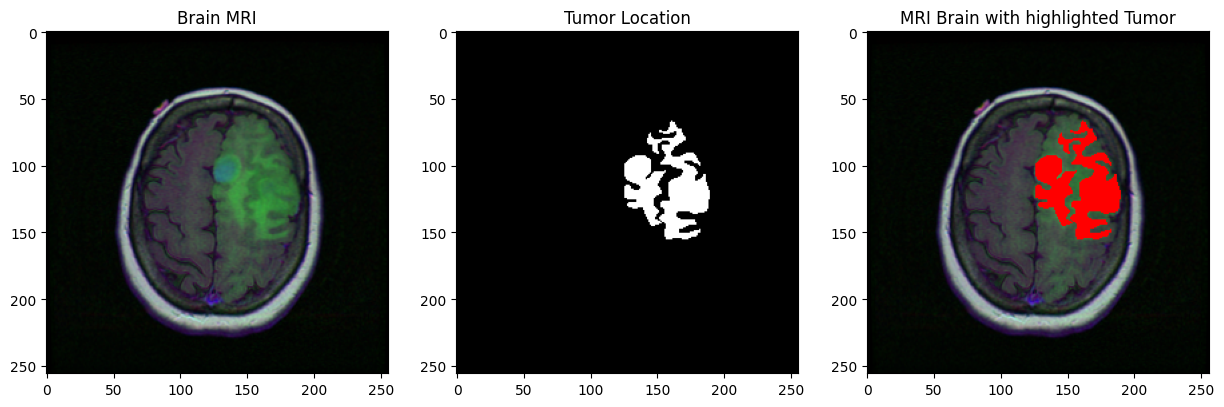

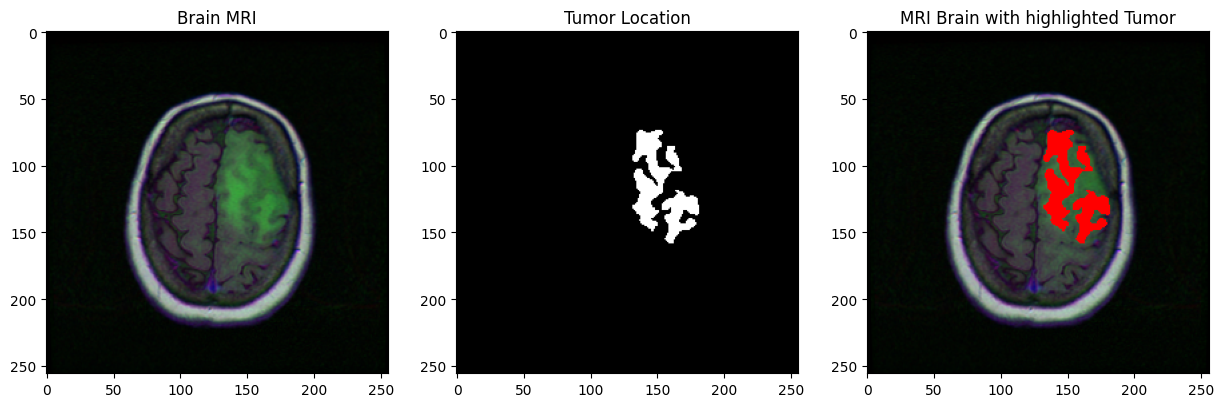

In [12]:
# Data vizualisation
# SOURCE: https://www.kaggle.com/monkira/brain-mri-segmentation-using-unet-keras#Create-data-frame-and-split-data-on-train-set,-validation-set-and-test-set
# https://www.kaggle.com/saivikassingamsetty/brain-tumor-segmentation-with-unet/notebook

for i in range(1,40, 2):
    img_path=brain_scans[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)

    #Plot the Brain MRI scans
    original = img.copy()
    fig, ax = plt.subplots(1,3,figsize = (15,5))
    ax[0].imshow(original)
    ax[0].set_title("Brain MRI")

    # Plot the corresponding mask
    main = original.copy()
    mask = msk.copy()
    ax[1].imshow(mask)
    ax[1].set_title("Tumor Location")

    # Plot the Brain MRI scan with their mask
    main = original.copy()
    label = cv2.imread(msk_path)
    sample = np.array(np.squeeze(label), dtype = np.uint8)
    contours, hier = cv2.findContours(sample[:,:,0],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(main, contours, -1,[255,0,0], thickness=-1)
    ax[2].imshow(sample_over_gt)
    ax[2].set_title("MRI Brain with highlighted Tumor")

# 3. Suddivisione del dataset in training, validation e testing set.

Di seguito, secondo norma del machine learning, il dataset iene diviso in training, validation e testing set. Tuttavia non si dispone della capacita di calcolo necessaria per svolgere un fine-tuning accurato per gli iperparametri della rete. Tuttavia, speando in futuri sviluppi, si decide di mantenere il codice in questo modo, sperando in una futuro aumento della capacita di calcolo disponibile.

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(img_df,test_size = 0.1)
train, val = train_test_split(train,test_size = 0.2)
print(train.values.shape)
print(val.values.shape)
print(test.values.shape)

train.head()
val.head()

(2828, 2)
(708, 2)
(393, 2)


image_path  \
35    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3442  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
66    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2824  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1355  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  
35    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3442  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
66    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2824  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1355  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

# 4. Costruzione di un modello di segmentazione


Adesso dobbiamo sostruire il modello, ma per prima cosa dobbiamo implementare delle classi che possano lavorare in sinergia con Keras, in maniera tale da poter fornire coppie adeguate (immagine-maschera) di allenamento alla rete durante il trianing.

## 4.1 Data augmentation, adjustment e data generation

In [14]:
# SOURCE: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [15]:
# iperparametri di allenamento
EPOCHS = 100
BATCH_SIZE = 32
im_height = 256
im_width = 256

In [16]:
# dizionario delle trasformazioni
train_generator_args = dict(width_shift_range=0.05,
                            height_shift_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest'
                           )

# generatori
train_gen = train_generator(train, BATCH_SIZE,
                            train_generator_args,
                            target_size=(im_height,
                            im_width)
                           )
test_gen = train_generator(val, BATCH_SIZE,
                            dict(),
                            target_size=(im_height, im_width)
                            )

## 4.2 Definizione della Loss Function
Di sotto ci si ispira al codice trovato al link riferito a pedice. Si nota come nella definizione del coefficiente di Dice venga agginto un parametro *smooth*. Questo viene fatto per evitare la divisione per zero.

Inoltre e anche importante questa definizione poiche rende il coefficiente di Dice una funzione di Loss secondo defizione, quindi interpretabile secondo un'ottica: *less is better*.  



Source: https://www.kaggle.com/monkira/brain-mri-segmentation-using-unet-keras

In [17]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

Successivamente si implementa la rete U-net vera e propria. In questo caso vi troviamo:
1. **Encoder** Cinque livelli di down-sampling: a ogni livello due convoluzioni 3×3 (“conv”), seguite da BatchNormalization e ReLU, quindi un MaxPooling 2×2 per ridurre le dimensioni spaziali e fornire alla rete invarianza per traslazione. I filtri raddoppiano a ogni step: 64 → 128 → 256 → 512 → 1024 canali, così il modello apprende feature di complessità crescente.

2. **Bottleneck** Dopo il quarto pooling c’è il livello più profondo con due convoluzioni da 1024 canali: qui si catturano feature molto astratte e a bassa risoluzione.

3. **Decoder** 4 livelli di up-sampling: a ogni livello si applica una trasposizione di convoluzione (Conv2DTranspose) 2×2 per raddoppiare le dimensioni spaziali, poi si concatena (“skip connection”) con l’output del corrispondente livello di encoder (conv4, conv3, conv2, conv1). Dopo ogni concatenazione due convoluzioni 3×3, BatchNormalization e ReLU, con numero di filtri che si dimezza (512 → 256 → 128 → 64).

4. **Output** Un’ultima convoluzione 1×1 con sigmoid, che produce un’unica mappa di valori in [0,1] per pixel, interpretabile come probabilità di “tumore” vs “sfondo”.

Le skip connections (concatenate) permettono di recuperare dettagli spaziali persi durante il pooling, migliorando la precisione dei bordi nelle maschere segmentate. Nel complesso, questa U-Net combina in modo simmetrico compressione ed espansione delle feature per ottenere segmentazioni accurate su immagini mediche.

In [12]:
def unet_complete(input_size=(256,256,3)):

    # Input
    inputs = Input(input_size)
    # encoder net
    # Stage 1
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs) # padding = same means that zero padding is used at the border of images
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1) # by default a stride of 1 is used, the stride being the step the filter takes across the image during the convolution operation
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1) # here the image's dimesions are halved by a max pooling operation, it both reduces the dimensions of the input volume and improves network's translation invariance

    # Stage 2
    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    # Stage 3
    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    # Stage 4
    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4) # so far the input image has been halfed in both directions 4 times, resulting in a 16x16 pixels image
    # this permits to capture very deep features in the image, by loosing spatial properties

    # Stage 5
    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    # decoder net
    # Upstage 1
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3) # now we start to rebuild the image, we have to tranform the 16x16 pixels onw we now have into the 256x256
    # modified one we want
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    # Upstage 2
    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3) # il layer concatenate prende in input due tensori con la stessa shape e li unisce lungo l'asse specificato
    # questa operazione permette di incorporare informazioni provenienti anche dalle skip connections, in questo caso dallo stage 4
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    # Upstage 3
    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    # l'operazione Conv2DTranspose e quella che permette di riottenere l'immagine con le dimensioni originali
    # nello specifico viene operata un'operazione di convoluzione inversa
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    # Upstage 4
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    # Output
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=inputs, outputs=conv10)

L'operazione che permette alla rete di funzionare e che in qualche modo risulta essere specifica della U-net e quella di convoluzione inversa.

Mentre la convoluzione puo essere immaginata come il risultato dello scorrimaneto di un filtro sopra un'immagine, la convoluzione inversa corrisponde esattamente all'operazione opposta.

Nello specifico, si parte da un pixel dell'immagine di partenza, e lo si moltiplica per i pesi del filtro utilizzato, ottenendo l'effetto desiderato di aumento della dimenzione di partenza. Infatti l'immagine risultato di questa operazione viene poi concatenata con le *skip connections*, che avranno una *shape* pari esattamente al doppio, in entrambe le direzioni, della immagine in input alla convoluzione inversa.

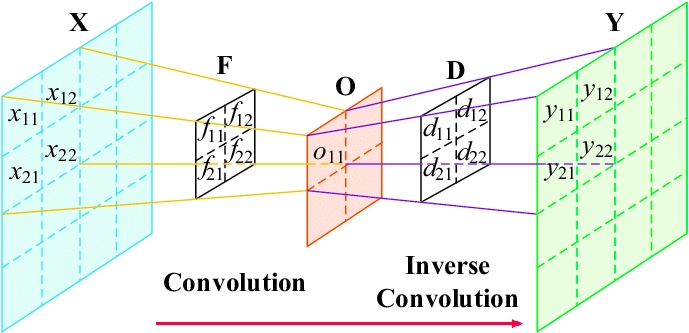

Un piccola nota e la seguente. Durante il *downsampling*, ovvero lungo l'*encoder*, le immagini vengono ridotte solamente dall'operazione di *max-pooling* applicata su un'area in pixel di (2,2). Questo permette di catturare con le convoluzioni il maggior quantitativo possibile di correlazioni spaziali nell'immaigne, per poi aumentare l'invarianze per tralazione della rete tramite il *pooling*.

Questo avviene perche di default lo stride di un layer di convoluzione e pari ad 1, a meno che non venga specificato diversamente.

Inoltre, sempre per mantenere le dimensioni dell'immagine in input, si imposta `padding = same`. Questo permette di aggiungere degli 0 ai bordi dell'immagine quando richiesto, in maniera tale da poter calcolare la onvoluzione anche sui pizel che si trovano ai bordi dell'immagine, non perdendo informazione.


Se tuttavia si fosse utilizzato `padding = valid`, in questo caso nessuno 0 di riempimento ai bordi. Nei casi in cui il filtro non ricopre il numero di pixel necessari alla convoluzione completa, semplicemente passa oltre, non tenendo conto dei pixel saltati. In questo modo si ottiene un'ulteriore riduzione della dimensionalita, oltre a quella ottenuta tramite il *max-pooling*. Volendo evitare questo effetto, si decide d utilizzare l'altro tipo di *padding*.

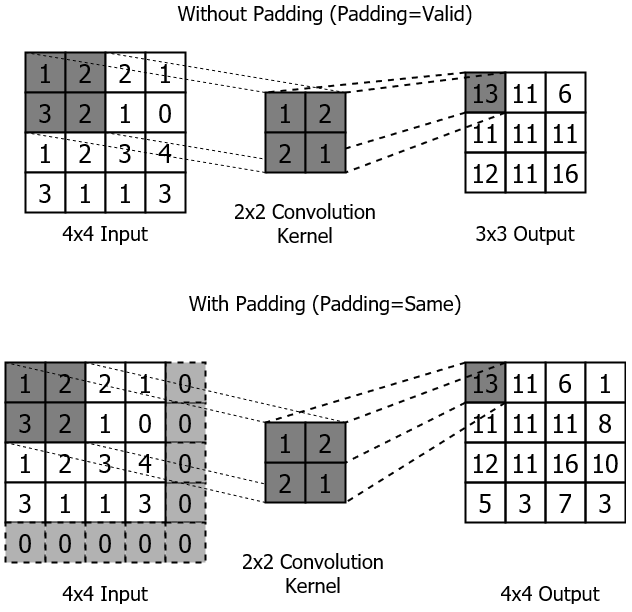

Notare come anche in questo caso si abbia uno *stride* pari ad 1

In [13]:
model = unet_complete()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]  

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [18]:
def unet_partial(input_size=(256,256,3)):

    # Input
    inputs = Input(input_size)

    # encoder
    # Stage 1
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    # Stage 2
    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    # Stage 3: deepest layer
    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)

    # decoder
    # Upstage 3
    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn3), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    # Upstage 4
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    # Output
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=inputs, outputs=conv10)



In [19]:
partial_model = unet_partial()
partial_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]  

 Total params: 1,865,409 (7.12 MB)

 Trainable params: 1,864,129 (7.11 MB)

 Non-trainable params: 1,280 (5.00 KB)

## 5.1. Setting Hyperparameters and Data Augmentation

In [20]:
# Define reducelr function to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=15,
                              min_delta=0.0001,
                              factor=0.2
                             )

# Define the earltstop function
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              mode='min',
                              verbose=1,
                              patience=20,
                              restore_best_weights = True
                             )

# Defining the Callbacks Function
checkpointer2 = [ModelCheckpoint('unet_brain_mri_seg.h5', verbose=1, save_best_only=True)]
callbacks = [checkpointer2, earlystopping, reduce_lr]

# 6. Training the Model

Lo snippet di codice che segue permette di allenare la rete.

In [ ]:
model_complete = unet_complete(input_size=(im_height, im_width, 3))


model_complete.compile(optimizer='adam', loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

history_complete = model_complete.fit(train_gen,
                    steps_per_epoch = int(len(train) / BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data = test_gen,
                    validation_steps = int(len(val) / BATCH_SIZE),
                    callbacks = callbacks)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 222s/step - binary_accuracy: 0.9020 - dice_coef: 0.1474 - iou: 0.0835 - loss: -0.1474  Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02289, saving model to unet_brain_mri_seg.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 21001s 239s/step - binary_accuracy: 0.9026 - dice_coef: 0.1485 - iou: 0.0843 - loss: -0.1485 - val_binary_accuracy: 0.9899 - val_dice_coef: 0.0229 - val_iou: 0.0123 - val_loss: -0.0229 - learning_rate: 0.0010
Epoch 2/100
24/88 ━━━━━━━━━━━━━━━━━━━━ 3:54:07 219s/step - binary_accuracy: 0.9891 - dice_coef: 0.4541 - iou: 0.3004 - loss: -0.4620

In [1]:
model_partial = unet_partial(input_size=(im_height, im_width, 3))


model_partial.compile(optimizer='adam', loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

history_partial = model_partial.fit(train_gen,
                    steps_per_epoch = int(len(train) / BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data = test_gen,
                    validation_steps = int(len(val) / BATCH_SIZE),
                    callbacks = callbacks)

NameError: name 'unet_partial' is not defined

# 7. Segmentation Model Evaluation

Infine si stampano alcuni grafici che sono utili per capire la performance della rete, dopo 100 epoche di allenamento, senza fine-tuning degli iperparametri.

#### modello completo

In [ ]:
history_complete = history_complete.history

list_traindice = history_complete['dice_coef']
list_valdice = history_complete['val_dice_coef']

list_trainjaccard = history_complete['iou']
list_valjaccard = history_complete['val_iou']

list_trainloss = history_complete['loss']
list_valloss = history_complete['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(list_valloss, 'b-', label='validation loss')
plt.plot(list_trainloss,'r-', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Loss graph', fontsize = 15)
plt.legend(['train', 'val'])
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(list_valdice, 'b-', label= 'validation_dice_coef')
plt.plot(list_traindice, 'r-', label= 'train_dice_coef')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Dice coefficient', fontsize = 15)
plt.legend(['train', 'val'])
plt.legend(loc='best')
plt.show()

NameError: name 'history' is not defined

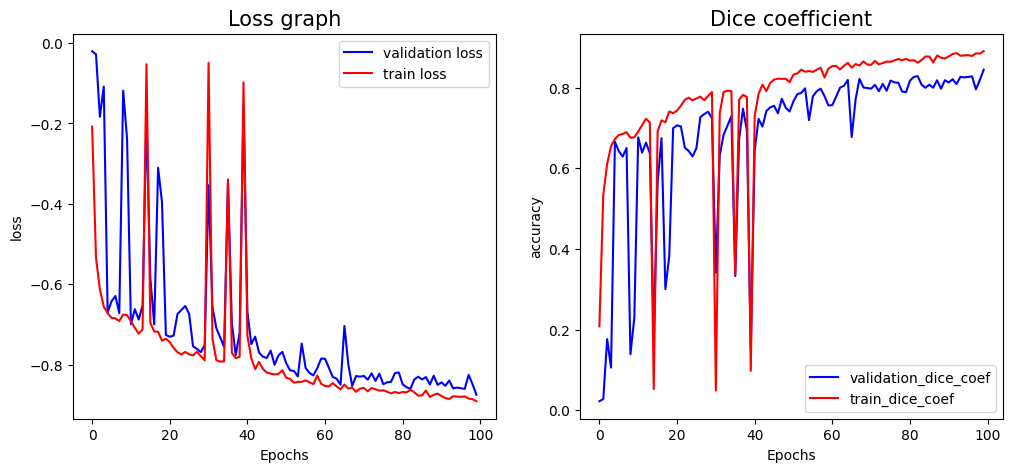

In [ ]:
test_gen = train_generator(test,
                           BATCH_SIZE,
                           dict(),
                           target_size=(im_height, im_width))

results = model_complete.evaluate(test_gen,
                         steps=len(test) / BATCH_SIZE)

print("Test lost: ",results[0]) # -0.83
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

#### modello parziale

In [ ]:
history_partial = history_partial.history

list_traindice = history_partial['dice_coef']
list_valdice = history_partial['val_dice_coef']

list_trainjaccard = history_partial['iou']
list_valjaccard = history_partial['val_iou']

list_trainloss = history_partial['loss']
list_valloss = history_partial['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(list_valloss, 'b-', label='validation loss')
plt.plot(list_trainloss,'r-', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Loss graph', fontsize = 15)
plt.legend(['train', 'val'])
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(list_valdice, 'b-', label= 'validation_dice_coef')
plt.plot(list_traindice, 'r-', label= 'train_dice_coef')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Dice coefficient', fontsize = 15)
plt.legend(['train', 'val'])
plt.legend(loc='best')
plt.show()

In [ ]:
test_gen = train_generator(test,
                           BATCH_SIZE,
                           dict(),
                           target_size=(im_height, im_width))

results = model_partial.evaluate(test_gen,
                         steps=len(test) / BATCH_SIZE)

print("Test lost: ",results[0]) # -0.55
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

# 8. Saving the model

In [ ]:
# Salvare in formato nativo Keras v3 (.keras)
model_complete.save('complete_unet_brain_mri_seg.keras')
model_partial.save('partial_unet_brain_mri_seg.keras')